In [1]:
# stateful 
#https://towardsdatascience.com/feature-scaling-and-normalisation-in-a-nutshell-5319af86f89b
#https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data
#https://github.com/yashk2810/Predicting-Next-Character-using-RNN/blob/master/Predicting%20Next%20character.ipynb
#https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/blob/master/Finance_Stock_Crypto_Trading/Bitcoin_Price_Prediction_with_LSTM.ipynb

In [2]:
pip install python-binance

     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 288 kB 32.2 MB/s 
     |████████████████████████████████| 103 kB 72.8 MB/s 
     |████████████████████████████████| 1.1 MB 50.9 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 144 kB 51.7 MB/s 
     |████████████████████████████████| 271 kB 75.1 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 


In [3]:
pip install websocket_client

     |████████████████████████████████| 53 kB 1.6 MB/s 


In [34]:
from binance.client import Client
from binance.enums import *
import time, datetime
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import math
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# **data scraping**

**OHLC data:**
An OHLC chart is a type of bar chart that shows open, high, low, and closing prices for each period. 

In [5]:
SOCKET = "wss://stream.binance.com:9443/ws/btcusdt@kline_1m"
TRADE_SYMBOL = 'BTCUSDT'
TRADE_SYMBOL_HISTORY = 'BTCUSDT'
API_KEY = 'ziew'
API_SECRET = 'ziew'

In [6]:
client = Client(API_KEY, API_SECRET)#, tld='us')

In [7]:

def GetHistoricalData(howLong):
    howLong = howLong
    # Calculate the timestamps for the binance api function
    untilThisDate = datetime.now()
    # sinceThisDate = untilThisDate - datetime.timedelta(days = howLong)
    sinceThisDate = untilThisDate - timedelta(hours = howLong)
    # Execute the query from binance - timestamps must be converted to strings !
    candle = client.get_historical_klines(TRADE_SYMBOL_HISTORY, Client.KLINE_INTERVAL_1MINUTE, str(sinceThisDate), str(untilThisDate))
    # print("TYPE", type(candle),"\n",candle)

    # Create a dataframe to label all the columns returned by binance so we work with them later.
    df = pd.DataFrame(candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    # as timestamp is returned in ms, let us convert this back to proper timestamps.
    df.dateTime = pd.to_datetime(df.dateTime, unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
    # df.set_index('dateTime', inplace=True)

    df["open"] = df.open.astype(float)
    df["high"] = df.high.astype(float)
    df["low"] = df.low.astype(float)
    df["close"] = df.close.astype(float)
    df["volume"] = df.volume.astype(float)

    # Get rid of columns we do not need
    df = df.drop(['quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore','closeTime'], axis=1)

    return df

In [8]:
print("Launching script...")
df=GetHistoricalData(24*60) # TAKE INTO ACCOUNT GMT-2 #10 days

Launching script...


In [9]:
df.tail()

,dateTime,open,high,low,close,volume
86395,2022-02-08 22:42:00,44058.01,44064.82,43993.49,43994.07,9.86785
86396,2022-02-08 22:43:00,43994.07,44008.75,43992.12,44000.04,3.14917
86397,2022-02-08 22:44:00,44000.04,44049.99,44000.04,44004.49,4.92256
86398,2022-02-08 22:45:00,44004.49,44004.50,43979.00,43982.43,6.25533
86399,2022-02-08 22:46:00,43986.13,44049.99,43979.83,44018.01,8.84105


In [10]:
df.shape

(86400, 6)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dateTime  86400 non-null  object 
 1   open      86400 non-null  float64
 2   high      86400 non-null  float64
 3   low       86400 non-null  float64
 4   close     86400 non-null  float64
 5   volume    86400 non-null  float64
dtypes: float64(5), object(1)
memory usage: 4.0+ MB


In [12]:
include =['float', 'int']
df.describe(include = include)

,open,high,low,close,volume
count,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000
mean,43588.812162,43613.518337,43564.182355,43588.761266,27.016076
std,4619.579177,4618.216955,4620.461916,4619.547082,42.795847
min,33050.110000,33139.860000,32917.170000,33056.980000,0.727330
25%,40732.120000,40771.740000,40690.477500,40732.112500,9.604860
50%,43113.170000,43131.775000,43092.845000,43113.275000,15.938165
75%,47397.890000,47424.912500,47372.550000,47397.890000,28.642575
max,51956.660000,52088.000000,51927.880000,51956.650000,1541.853250


In [13]:
#covert datatime column from object dtype to datetime dtype
df["dateTime"] = df.dateTime.astype('datetime64[ns]')

In [14]:
df = df.rename({'close': 'price'}, axis='columns')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dateTime  86400 non-null  datetime64[ns]
 1   open      86400 non-null  float64       
 2   high      86400 non-null  float64       
 3   low       86400 non-null  float64       
 4   price     86400 non-null  float64       
 5   volume    86400 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.0 MB


In [16]:
# copy by value
df2 = df.copy()

In [17]:
#Set time column as Index
df.set_index('dateTime',inplace=True)

In [18]:
df.tail()

,open,high,low,price,volume
dateTime,,,,,
2022-02-08 22:42:00,44058.01,44064.82,43993.49,43994.07,9.86785
2022-02-08 22:43:00,43994.07,44008.75,43992.12,44000.04,3.14917
2022-02-08 22:44:00,44000.04,44049.99,44000.04,44004.49,4.92256
2022-02-08 22:45:00,44004.49,44004.50,43979.00,43982.43,6.25533
2022-02-08 22:46:00,43986.13,44049.99,43979.83,44018.01,8.84105


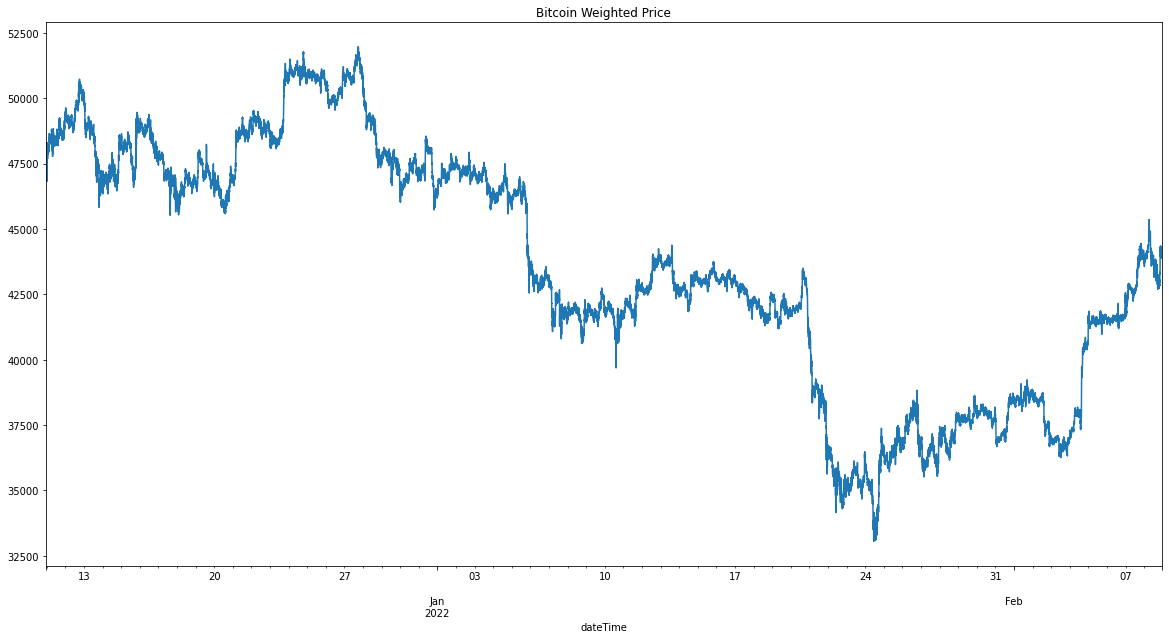

In [19]:
#plot
df['price'].plot(title = "Bitcoin Weighted Price",x = "time",y = "price",figsize=(20, 10))
plt.show()

In [20]:
#df['price'].rolling(60).mean().plot(figsize=(20, 10))

In [21]:
#df.set_index("dateTime").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

## **Time series**

Text(0.5, 1.0, 'Weekly Lag')

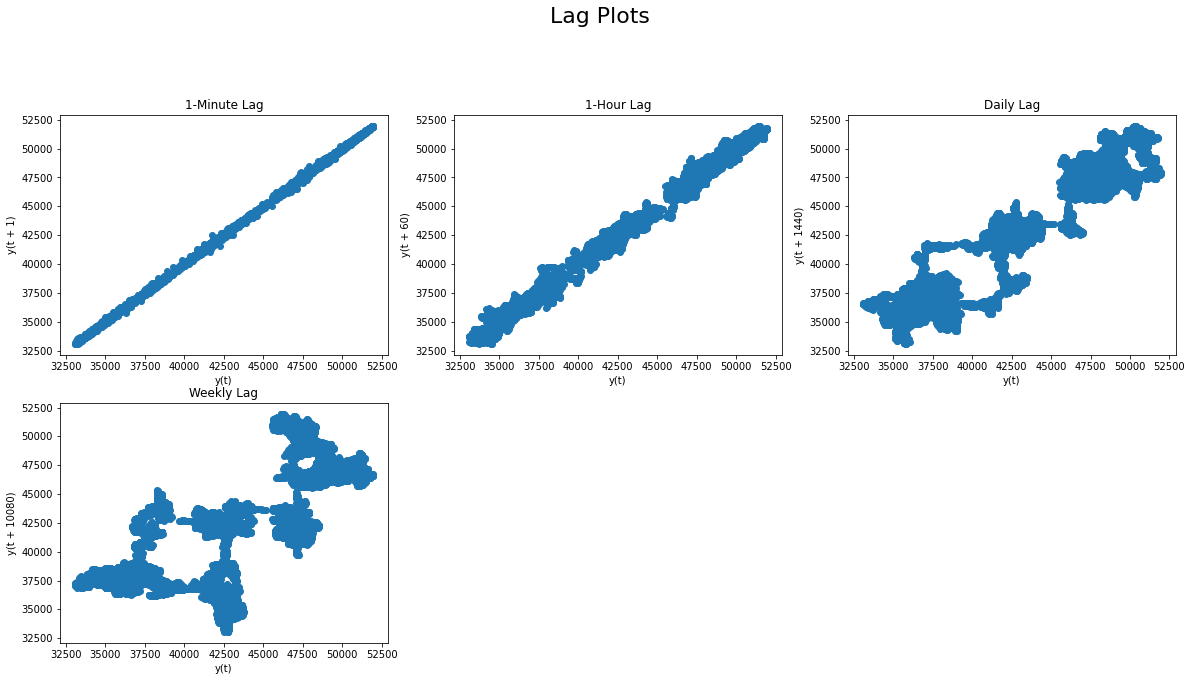

In [22]:
#Auto-correlation 
plt.figure(figsize=(20,15))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(df['price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(df['price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(df['price'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(df['price'], lag=10080) #weekly lag
plt.title('Weekly Lag')

In [23]:
df2

,dateTime,open,high,low,price,volume
0,2021-12-10 22:47:00,47888.82,47893.58,47862.67,47865.55,13.42968
1,2021-12-10 22:48:00,47865.55,47884.55,47865.54,47874.84,13.81605
2,2021-12-10 22:49:00,47874.84,47886.77,47873.05,47885.98,6.03346
3,2021-12-10 22:50:00,47885.99,47885.99,47640.03,47650.64,59.94128
4,2021-12-10 22:51:00,47663.74,47663.74,47454.55,47528.60,93.55243
...,...,...,...,...,...,...
86395,2022-02-08 22:42:00,44058.01,44064.82,43993.49,43994.07,9.86785
86396,2022-02-08 22:43:00,43994.07,44008.75,43992.12,44000.04,3.14917
86397,2022-02-08 22:44:00,44000.04,44049.99,44000.04,44004.49,4.92256
86398,2022-02-08 22:45:00,44004.49,44004.50,43979.00,43982.43,6.25533


In [24]:
df['date'] = pd.to_datetime(df.index,unit='H').date
display(df.head())
group = df.groupby('date')
new_df = group['price'].mean()
display(new_df.head())

,open,high,low,price,volume,date
dateTime,,,,,,
2021-12-10 22:47:00,47888.82,47893.58,47862.67,47865.55,13.42968,2021-12-10
2021-12-10 22:48:00,47865.55,47884.55,47865.54,47874.84,13.81605,2021-12-10
2021-12-10 22:49:00,47874.84,47886.77,47873.05,47885.98,6.03346,2021-12-10
2021-12-10 22:50:00,47885.99,47885.99,47640.03,47650.64,59.94128,2021-12-10
2021-12-10 22:51:00,47663.74,47663.74,47454.55,47528.60,93.55243,2021-12-10


date
2021-12-10    47529.232192
2021-12-11    48454.469840
2021-12-12    49557.327361
2021-12-13    48182.316597
2021-12-14    47187.779042
Name: price, dtype: float64

In [25]:
new_df.shape

(61,)

## Data Split

In [26]:
# Train data from 1 to Total data length - 50 days 
train = new_df[:50].values
# Test data : the last 50 days
test = new_df[50:].values

In [27]:
print(train.shape,test.shape)

(50,) (11,)


In [28]:
test

array([37808.81938889, 37939.88866667, 37551.46377778, 38549.89975   ,
       38033.70225694, 36796.28565278, 38655.36913194, 41507.13375694,
       41591.23949306, 43092.74283333, 43828.77239941])

## Data Scaling

Standard Scaler for Data

we first need to split the data into training and test set before applying normalization over data.

we should perform feature normalisation over the training data. Then perform normalisation on testing instances as well, but this time using the mean and variance of training explanatory variables. In this way, we can test and evaluate whether our model can generalize well to new, unseen data points

In [29]:
train = train.reshape(-1,1)
test = test.reshape(-1,1)

In [30]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
#scaled_train  = scaler.fit_transform(train)

scaler = scaler.fit(train)
scaled_train = scaler.transform(train)

#scaler_test  = StandardScaler(copy=True, with_mean=True, with_std=True)
scaled_test   = scaler.transform(test)


In [31]:
scaled_test

array([[-1.51006271],
       [-1.48068607],
       [-1.567744  ],
       [-1.34396386],
       [-1.45965956],
       [-1.7370026 ],
       [-1.32032494],
       [-0.68115697],
       [-0.66230629],
       [-0.32577331],
       [-0.1608065 ]])

## Dataset Generator for LSTM

The input will be -> 1, 2, 3, 4, 5, 6, 7 

And the output will be -> 8 
-------
The input will be -> 2, 3, 4, 5, 6, 7, 8 

And the output will be -> 9
-------
...

In [35]:
def data_generator(data,lookback  = 7):
  x = [data[i:(i + lookback), 0] for i in range(len(data)-lookback)]
  y = [data[i+lookback, 0] for i in range(len(data)-lookback)]
  return np.array(x), np.array(y)

In [36]:
trainX, trainY = data_generator(scaled_train)

testX, testY = data_generator(scaled_test)

In [37]:
print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (43, 7)
trainY:  (43,)
testX:  (4, 7)
testY (4,)


For LSTM we need to reshape input to be a 3D Tensor of samples, time steps, features.

The number of time steps is equal to the number of LSTM cells

In [38]:
# We use the reshape() function on the NumPy array to reshape the one-dimensional array into a three-dimensional array.
def data_reshape(data):
  return np.reshape(data, (data.shape[0], data.shape[1], 1))

In [39]:
trainX = data_reshape(trainX)
testX = data_reshape(testX)

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (43, 7, 1)
Shape of testX:  (4, 7, 1)


## LSTM Model

to convert an input sequence into an output sequence we use **return_sequences=True**.

In [40]:
# the input to every LSTM layer must be three-dimensional.
model = Sequential()
# input_shape is supposed to be (timesteps, n_features).
model.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))



# output layer
model.add(Dense(units = 1))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#checkpoint_path = 'my_best_model.hdf5'
'''
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
'''

earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ep = 20
BS = 32

callbacks = [earlystopping]
# callbacks = [checkpoint]


history = model.fit(trainX, trainY, batch_size = BS, epochs = ep, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/20
2/2 [==============================] - 3s 575ms/step - loss: 1.0336 - val_loss: 0.1714
Epoch 2/20
2/2 [==============================] - 0s 31ms/step - loss: 0.9154 - val_loss: 0.1171
Epoch 3/20
2/2 [==============================] - 0s 31ms/step - loss: 0.8456 - val_loss: 0.0723
Epoch 4/20
2/2 [==============================] - 0s 30ms/step - loss: 0.7654 - val_loss: 0.0424
Epoch 5/20
2/2 [==============================] - 0s 31ms/step - loss: 0.6733 - val_loss: 0.0371
Epoch 6/20
2/2 [==============================] - 0s 29ms/step - loss: 0.5937 - val_loss: 0.0745
Epoch 7/20
2/2 [==============================] - 0s 40ms/step - loss: 0.5043 - val_loss: 0.1871
Epoch 8/20
2/2 [==============================] - 0s 28ms/step - loss: 0.4002 - val_loss: 0.4302
Epoch 9/20
2/2 [==============================] - 0s 30ms/step - loss: 0.3495 - val_loss: 0.8894
Epoch 10/20
2/2 [==============================] - 0s 29ms/step - loss: 0.2856 - val_loss: 1.6666


In [43]:
# Save the model
model.save_weights('LSTM_RNN_.h5')

In [44]:
# Load the model
model.load_weights('LSTM_RNN_.h5')

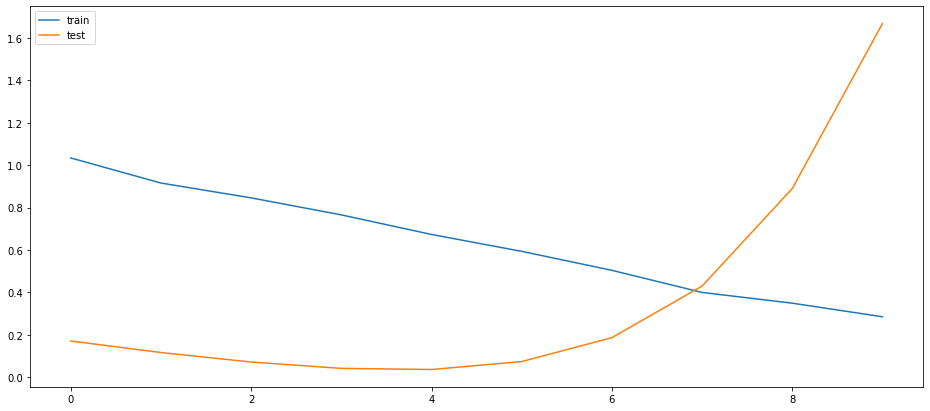

In [45]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

## LSTM Predictions vs. Actual testY

We need to transfer the scale data to the original data (real value), So we are going to use **inverse_transform** to Scale back the data to the original representation.

In [46]:

predicted_test_data = model.predict(testX)
predicted_test_data = scaler.inverse_transform(predicted_test_data.reshape(-1, 1))
test_actual = scaler.inverse_transform(testY.reshape(-1, 1))

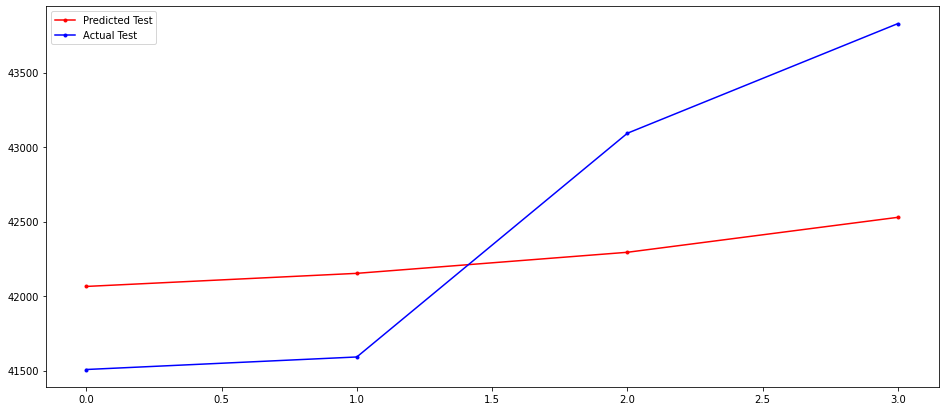

In [47]:
plt.figure(figsize=(16,7))

plt.plot(predicted_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, 'b', marker='.', label='Actual Test')

plt.legend()
plt.show()

##Mean squared error

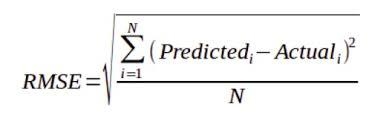

In [48]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model.predict(trainX)

predicted_btc_price_train_data = scaler.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler.inverse_transform(trainY.reshape(-1, 1))

In [49]:
# Train Data
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)

Test RMSE: 3500.116


In [50]:
# Test Data
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

Test RMSE: 859.464



##Future Price Predictions

For 10 Days beyond the actual trading days for which I dont have the ground truth data (i.e. for 10-days into future for which I dont have actual Trading Price yet)
We are going to forecast the Bitcoin Prices for the next 10 days from today.


In [81]:
days = 10
lookback  = testX.shape[1]

In [152]:
testX_last_n_days =testX[-1] #testX[testX.shape[0] - lookback :  ]
testX_last_n_days = np.reshape(testX_last_n_days, (1, testX.shape[1], 1))
print(testX_last_n_days.shape)
print(testX_last_n_days)
print(type(testX_last_n_days))

(1, 7, 1)
[[[-1.34396386]
  [-1.45965956]
  [-1.7370026 ]
  [-1.32032494]
  [-0.68115697]
  [-0.66230629]
  [-0.32577331]]]
<class 'numpy.ndarray'>


In [150]:
# convert testX_last_n_days to queue
queue = testX_last_n_days
predicted_values = []
print(queue)

for i in range(days):
  
  predicted_value = model.predict(queue)[0]  #predicted_value = model.predict(testX_last_n_days)
  queue = queue.tolist()

  queue[0].pop(0)

  queue[0].append(predicted_value)

  predicted_value = scaler.inverse_transform(predicted_value.reshape(-1, 1))
  predicted_values.append(predicted_value)


  next_price = scaler.inverse_transform(queue[0][-1].reshape(-1, 1))
  last_price = scaler.inverse_transform(np.array(queue[0][-2]).reshape(-1, 1))
  if next_price > last_price:
    print("Buy crypto || +{s} ({p} %)".format(s = next_price - last_price, p = 1-(last_price/next_price)))
  else:
    print("Sell crypto || -{s} ({p} %)".format(s = last_price - next_price, p = 1-(next_price/last_price)))

  queue = np.asarray(queue).astype('float32')
 


[[[-1.34396386]
  [-1.45965956]
  [-1.7370026 ]
  [-1.32032494]
  [-0.68115697]
  [-0.66230629]
  [-0.32577331]]]
Sell crypto || -[[564.23892708]] ([[0.0130936]] %)
Buy crypto || +[[213.44136223]] ([[0.00499372]] %)
Buy crypto || +[[262.15723447]] ([[0.0060961]] %)
Buy crypto || +[[330.34089668]] ([[0.00762306]] %)
Buy crypto || +[[233.42584317]] ([[0.00535775]] %)
Buy crypto || +[[95.56617363]] ([[0.0021887]] %)
Buy crypto || +[[99.13239482]] ([[0.00226523]] %)
Buy crypto || +[[31.40710143]] ([[0.00071716]] %)
Buy crypto || +[[64.42248063]] ([[0.00146887]] %)
Buy crypto || +[[56.57168044]] ([[0.00128821]] %)


In [151]:
print("Forecast for the next %2d Days Beyond the actual trading days "%  (days))
print(np.array(predicted_values))
print(np.array(predicted_values).shape)

Forecast for the next 10 Days Beyond the actual trading days 
[[[42528.504]]

 [[42741.945]]

 [[43004.1  ]]

 [[43334.44 ]]

 [[43567.867]]

 [[43663.434]]

 [[43762.566]]

 [[43793.973]]

 [[43858.395]]

 [[43914.965]]]
(10, 1, 1)


## Plot future Predictions (Future 10-days ) 

In [122]:
predicted = np.array(predicted_values).flatten()

In [123]:
predicted

array([42528.504, 42741.945, 43004.1  , 43334.44 , 43567.867, 43663.434,
       43762.566, 43793.973, 43858.395, 43914.965], dtype=float32)

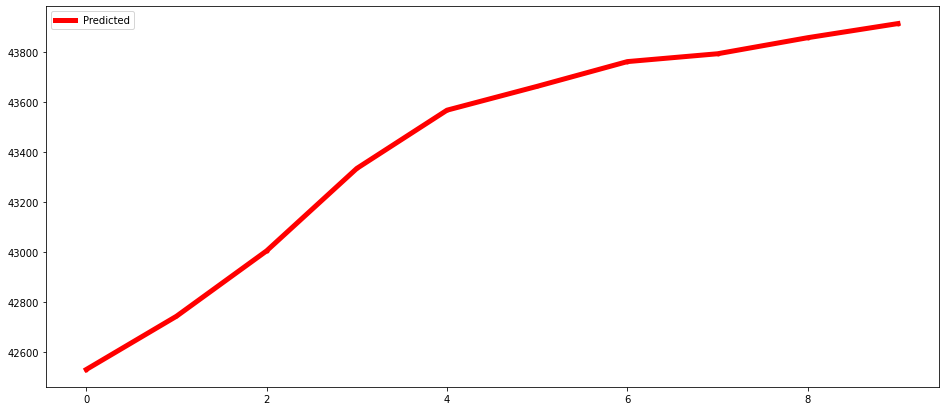

In [124]:
plt.figure(figsize=(16,7))

plt.plot(predicted, 'r', marker='.',lw=5, label='Predicted')

#plt.plot(yy, marker='.',lw=5, label='Actual')

plt.legend()

plt.show()